In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import scipy
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm import tqdm
%matplotlib inline
import pickle
pd.options.display.max_columns = 200

In [2]:
SEED=519 
kf = KFold(5, shuffle=True, random_state=SEED)

In [3]:
target = 'deal_probability'
y_train = pd.read_csv('data/train.csv', usecols=['activation_date', 'deal_probability'], parse_dates=['activation_date']) \
            .sort_values('activation_date') \
            .reset_index(drop=True).deal_probability.values

In [4]:
plants = pd.read_csv('all_features_plantsgo.csv.zip')

In [5]:
print(plants.shape)
plants

(2011862, 153)


,price,image_top_1,item_seq_number,activation_weekday,avg_days_up_user,avg_times_up_user,n_user_items,"cat_features_user_id_category_name_Одежда, обувь, аксессуары",cat_features_user_id_category_name_Детская одежда и обувь,cat_features_user_id_category_name_Товары для детей и игрушки,cat_features_user_id_category_name_Предложение услуг,cat_features_user_id_category_name_Квартиры,cat_features_user_id_category_name_Ремонт и строительство,cat_features_user_id_category_name_Мебель и интерьер,cat_features_user_id_category_name_Телефоны,cat_features_user_id_category_name_Коллекционирование,cat_features_user_id_category_name_Автомобили,"cat_features_user_id_category_name_Дома, дачи, коттеджи",cat_features_user_id_category_name_Товары для компьютера,cat_features_user_id_category_name_Аудио и видео,cat_features_user_id_category_name_Красота и здоровье,cat_features_user_id_category_name_Спорт и отдых,cat_features_user_id_category_name_Бытовая техника,cat_features_user_id_category_name_Часы и украшения,cat_features_user_id_category_name_Книги и журналы,cat_features_user_id_category_name_Оборудование для бизнеса,cat_features_user_id_category_name_Земельные участки,cat_features_user_id_category_name_Посуда и товары для кухни,cat_features_user_id_category_name_Товары для животных,cat_features_user_id_category_name_Фототехника,"cat_features_user_id_category_name_Игры, приставки и программы",cat_features_user_id_category_name_Грузовики и спецтехника,cat_features_user_id_category_name_Коммерческая недвижимость,cat_features_user_id_category_name_Оргтехника и расходники,cat_features_user_id_category_name_Растения,cat_features_user_id_category_name_Гаражи и машиноместа,cat_features_user_id_category_name_Планшеты и электронные книги,cat_features_user_id_category_name_Велосипеды,cat_features_user_id_category_name_Комнаты,cat_features_user_id_category_name_Музыкальные инструменты,cat_features_user_id_category_name_Собаки,cat_features_user_id_category_name_Ноутбуки,cat_features_user_id_category_name_Другие животные,cat_features_user_id_category_name_Охота и рыбалка,cat_features_user_id_category_name_Продукты питания,cat_features_user_id_category_name_Настольные компьютеры,cat_features_user_id_category_name_Кошки,cat_features_user_id_category_name_Аквариум,cat_features_user_id_category_name_Мотоциклы и мототехника,cat_features_user_id_category_name_Птицы,cat_features_user_id_category_name_Водный транспорт,cat_features_user_id_category_name_Готовый бизнес,cat_features_user_id_category_name_Билеты и путешествия,cat_features_user_id_category_name_Недвижимость за рубежом,price_pred,price_pred_onlydescription,price_pred_all,ridge_preds,ridge_preds_title,ridge_preds_description,ga,region,city,parent_category_name,category_name,user_type,param_1,param_2,param_3,title_tfidf_svd_1,title_tfidf_svd_2,title_tfidf_svd_3,title_tfidf_svd_4,title_tfidf_svd_5,description_tfidf_svd_1,description_tfidf_svd_2,description_tfidf_svd_3,description_tfidf_svd_4,description_tfidf_svd_5,region_mean_price,region_mean_image_top_1,region_mean_item_seq_number,region_mean_price_pred,region_mean_price_pred_all,region_mean_ridge_preds,city_mean_price,city_mean_image_top_1,city_mean_item_seq_number,city_mean_price_pred,city_mean_price_pred_all,city_mean_ridge_preds,parent_category_name_mean_price,parent_category_name_mean_image_top_1,parent_category_name_mean_item_seq_number,parent_category_name_mean_price_pred,parent_category_name_mean_price_pred_all,parent_category_name_mean_ridge_preds,category_name_mean_price,category_name_mean_image_top_1,category_name_mean_item_seq_number,category_name_mean_price_pred,category_name_mean_price_pred_all,category_name_mean_ridge_preds,user_type_mean_price,user_type_mean_image_top_1,user_type_mean_item_seq_number,user_type_mean_price_pred,user_type_mean_price_pred_all,user_type_mean_ridge_preds,param_1_mean_price,param_1_mean_image_top_1,param_1_mean_item_seq_number,param_1_mean_price_pred,param_1_mean_price_pred_all,param_1_mean_ridge_preds,param_2_

In [6]:
#plants.drop([col for col in plants.columns if 'ridge_preds' in col], axis=1, inplace=True)        
plants.columns.tolist()

['price',
 'image_top_1',
 'item_seq_number',
 'activation_weekday',
 'avg_days_up_user',
 'avg_times_up_user',
 'n_user_items',
 'cat_features_user_id_category_name_Одежда, обувь, аксессуары',
 'cat_features_user_id_category_name_Детская одежда и обувь',
 'cat_features_user_id_category_name_Товары для детей и игрушки',
 'cat_features_user_id_category_name_Предложение услуг',
 'cat_features_user_id_category_name_Квартиры',
 'cat_features_user_id_category_name_Ремонт и строительство',
 'cat_features_user_id_category_name_Мебель и интерьер',
 'cat_features_user_id_category_name_Телефоны',
 'cat_features_user_id_category_name_Коллекционирование',
 'cat_features_user_id_category_name_Автомобили',
 'cat_features_user_id_category_name_Дома, дачи, коттеджи',
 'cat_features_user_id_category_name_Товары для компьютера',
 'cat_features_user_id_category_name_Аудио и видео',
 'cat_features_user_id_category_name_Красота и здоровье',
 'cat_features_user_id_category_name_Спорт и отдых',
 'cat_feature

In [7]:
train_plants = plants.loc[:len(y_train)-1,:]
test_plants = plants.loc[len(y_train):,:].reset_index(drop=True)
del plants; gc.collect()

64

In [8]:
train_plants.shape, test_plants.shape

((1503424, 153), (508438, 153))

In [9]:
'''
origin = pd.read_csv('data/train.csv', usecols=['activation_date', 'item_id'], parse_dates=['activation_date'])
train_item_id = origin.sort_values('activation_date').reset_index(drop=True).item_id.values
del origin; gc.collect()

origin = pd.read_csv('data/test.csv', usecols=['item_id'])
test_item_id = origin.item_id.values
del origin; gc.collect()

train = pickle.load(open('train_selected_features', 'rb'))
test = pickle.load(open('test_selected_features', 'rb'))
train['item_id'] = train_item_id
test['item_id'] = test_item_id

train = train.merge(train_plants, on='item_id', how='left')
test = test.merge(test_plants, on='item_id', how='left')

train.drop('item_id', axis=1, inplace=True)
test.drop('item_id', axis=1, inplace=True)

del train_plants, test_plants; gc.collect()
'''

train = train_plants
test = test_plants

origin = pd.read_csv('data/train.csv', usecols=['activation_date', 'item_id'], parse_dates=['activation_date'])
train['activation_date'] = origin['activation_date']
train = train.sort_values('activation_date').reset_index(drop=True).drop('activation_date', axis=1)
train.drop('item_id', axis=1, inplace=True)
test.drop('item_id', axis=1, inplace=True)

C:\Users\khyeh\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
train = pd.concat([train, pickle.load(open('train_selected_features', 'rb'))], axis=1)
test = pd.concat([test, pickle.load(open('test_selected_features', 'rb'))], axis=1)

In [11]:
merged = {
    'train': train,
    'test': test,
    'y_train': y_train,
}

import pickle
pickle.dump(merged, open('merged.pkl', 'wb'))

In [12]:
print(train.shape)
train

(1503424, 257)


,price,image_top_1,item_seq_number,activation_weekday,avg_days_up_user,avg_times_up_user,n_user_items,"cat_features_user_id_category_name_Одежда, обувь, аксессуары",cat_features_user_id_category_name_Детская одежда и обувь,cat_features_user_id_category_name_Товары для детей и игрушки,cat_features_user_id_category_name_Предложение услуг,cat_features_user_id_category_name_Квартиры,cat_features_user_id_category_name_Ремонт и строительство,cat_features_user_id_category_name_Мебель и интерьер,cat_features_user_id_category_name_Телефоны,cat_features_user_id_category_name_Коллекционирование,cat_features_user_id_category_name_Автомобили,"cat_features_user_id_category_name_Дома, дачи, коттеджи",cat_features_user_id_category_name_Товары для компьютера,cat_features_user_id_category_name_Аудио и видео,cat_features_user_id_category_name_Красота и здоровье,cat_features_user_id_category_name_Спорт и отдых,cat_features_user_id_category_name_Бытовая техника,cat_features_user_id_category_name_Часы и украшения,cat_features_user_id_category_name_Книги и журналы,cat_features_user_id_category_name_Оборудование для бизнеса,cat_features_user_id_category_name_Земельные участки,cat_features_user_id_category_name_Посуда и товары для кухни,cat_features_user_id_category_name_Товары для животных,cat_features_user_id_category_name_Фототехника,"cat_features_user_id_category_name_Игры, приставки и программы",cat_features_user_id_category_name_Грузовики и спецтехника,cat_features_user_id_category_name_Коммерческая недвижимость,cat_features_user_id_category_name_Оргтехника и расходники,cat_features_user_id_category_name_Растения,cat_features_user_id_category_name_Гаражи и машиноместа,cat_features_user_id_category_name_Планшеты и электронные книги,cat_features_user_id_category_name_Велосипеды,cat_features_user_id_category_name_Комнаты,cat_features_user_id_category_name_Музыкальные инструменты,cat_features_user_id_category_name_Собаки,cat_features_user_id_category_name_Ноутбуки,cat_features_user_id_category_name_Другие животные,cat_features_user_id_category_name_Охота и рыбалка,cat_features_user_id_category_name_Продукты питания,cat_features_user_id_category_name_Настольные компьютеры,cat_features_user_id_category_name_Кошки,cat_features_user_id_category_name_Аквариум,cat_features_user_id_category_name_Мотоциклы и мототехника,cat_features_user_id_category_name_Птицы,cat_features_user_id_category_name_Водный транспорт,cat_features_user_id_category_name_Готовый бизнес,cat_features_user_id_category_name_Билеты и путешествия,cat_features_user_id_category_name_Недвижимость за рубежом,price_pred,price_pred_onlydescription,price_pred_all,ridge_preds,ridge_preds_title,ridge_preds_description,ga,region,city,parent_category_name,category_name,user_type,param_1,param_2,param_3,title_tfidf_svd_1,title_tfidf_svd_2,title_tfidf_svd_3,title_tfidf_svd_4,title_tfidf_svd_5,description_tfidf_svd_1,description_tfidf_svd_2,description_tfidf_svd_3,description_tfidf_svd_4,description_tfidf_svd_5,region_mean_price,region_mean_image_top_1,region_mean_item_seq_number,region_mean_price_pred,region_mean_price_pred_all,region_mean_ridge_preds,city_mean_price,city_mean_image_top_1,city_mean_item_seq_number,city_mean_price_pred,city_mean_price_pred_all,city_mean_ridge_preds,parent_category_name_mean_price,parent_category_name_mean_image_top_1,parent_category_name_mean_item_seq_number,parent_category_name_mean_price_pred,parent_category_name_mean_price_pred_all,parent_category_name_mean_ridge_preds,category_name_mean_price,category_name_mean_image_top_1,category_name_mean_item_seq_number,...,vgg16_image_pca_feature_6,vgg16_image_pca_feature_7,vgg16_image_pca_feature_8,vgg16_image_pca_feature_9,vgg16_image_pca_feature_10,vgg16_image_pca_feature_11,vgg16_image_pca_feature_12,vgg16_image_pca_feature_13,vgg16_image_pca_feature_14,vgg16_image_pca_feature_15,vgg16_image_pca_feature_16,vgg16_image_pca_feature_17,vgg16_image_pca_feature_18,vgg16_image_pca_feature_19,vgg16_image_pca_feature_20,vgg16_imag

In [13]:
from GridSearcher import data_loader, model_loader, fit_params, get_oof_predictions
ml = model_loader('lgb')

In [14]:
categorical = ['image_top_1', 'region', 'city', 'parent_category_name', 'category_name', 'user_type', 'param_1', 
               'param_2', 'param_3', 'lat_lon_hdbscan_cluster_05_03', 'lat_lon_hdbscan_cluster_10_03', 
               'lat_lon_hdbscan_cluster_20_03',]
numerical = [f for f in train.columns.tolist() if f not in categorical]

In [15]:
rounds = 24000
early_stop_rounds = 200

params = {
    'boosting_type': 'gbdt',
    'objective': 'xentropy',
    'metric': 'rmse',
    #'min_child_weight': 1.5,
    'num_leaves': 45,
    'max_depth': 9,
    'lambda_l2': 5.9,
    'lambda_l1': 3,
    'subsample': 1.,
    'colsample_bytree': .2,
    'colsample_bylevel': 1.,
    'learning_rate': 0.02,
    'seed': 2018,
    'nthread': 4,
    'silent': True,
}

ret = np.zeros((train.shape[0],))
ret_test = np.zeros((test.shape[0],))
ret_models = []
    
for train_ix, val_ix in kf.split(train):
    dtrain = lgb.Dataset(train.loc[train_ix,:], label=y_train[train_ix],)
                         #feature_name=train.columns.tolist(),
                         #categorical_feature=categorical)
    dvalid = lgb.Dataset(train.loc[val_ix,:], label=y_train[val_ix],)
                         #feature_name=train.columns.tolist(),
                         #categorical_feature=categorical)
    
    model = lgb.train(params, dtrain, 
                      valid_sets=[dtrain, dvalid], 
                      valid_names=['train', 'valid'],
                      num_boost_round=rounds, 
                      early_stopping_rounds=early_stop_rounds, 
                      verbose_eval=100)
    
    ret[val_ix] = model.predict(train.loc[val_ix,:])
    ret_test += model.predict(test)
    ret_models.append(model)
    
    del dtrain, dvalid
    
ret_test = ret_test / 5.

Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.225015	valid's rmse: 0.2258
[200]	train's rmse: 0.221376	valid's rmse: 0.222376
[300]	train's rmse: 0.219476	valid's rmse: 0.220697
[400]	train's rmse: 0.218209	valid's rmse: 0.219656
[500]	train's rmse: 0.217189	valid's rmse: 0.218852
[600]	train's rmse: 0.216328	valid's rmse: 0.218205
[700]	train's rmse: 0.215645	valid's rmse: 0.217721
[800]	train's rmse: 0.215112	valid's rmse: 0.217393
[900]	train's rmse: 0.214588	valid's rmse: 0.217077
[1000]	train's rmse: 0.214118	valid's rmse: 0.216812
[1100]	train's rmse: 0.213683	valid's rmse: 0.216578
[1200]	train's rmse: 0.213288	valid's rmse: 0.216375
[1300]	train's rmse: 0.212941	valid's rmse: 0.216224
[1400]	train's rmse: 0.212579	valid's rmse: 0.216057
[1500]	train's rmse: 0.212238	valid's rmse: 0.215906
[1600]	train's rmse: 0.21192	valid's rmse: 0.215775
[1700]	train's rmse: 0.211603	valid's rmse: 0.215654
[1800]	train's rmse: 0.211311	valid's rmse: 0.21

[15400]	train's rmse: 0.186539	valid's rmse: 0.213147
[15500]	train's rmse: 0.186382	valid's rmse: 0.213141
[15600]	train's rmse: 0.186223	valid's rmse: 0.213139
[15700]	train's rmse: 0.186069	valid's rmse: 0.213136
[15800]	train's rmse: 0.185911	valid's rmse: 0.213134
[15900]	train's rmse: 0.185747	valid's rmse: 0.213129
[16000]	train's rmse: 0.185589	valid's rmse: 0.213129
[16100]	train's rmse: 0.185424	valid's rmse: 0.213128
[16200]	train's rmse: 0.185254	valid's rmse: 0.21313
[16300]	train's rmse: 0.18509	valid's rmse: 0.213123
[16400]	train's rmse: 0.184928	valid's rmse: 0.21312
[16500]	train's rmse: 0.184773	valid's rmse: 0.213117
[16600]	train's rmse: 0.184612	valid's rmse: 0.213115
[16700]	train's rmse: 0.184447	valid's rmse: 0.213114
[16800]	train's rmse: 0.184284	valid's rmse: 0.213108
[16900]	train's rmse: 0.184128	valid's rmse: 0.213105
[17000]	train's rmse: 0.18397	valid's rmse: 0.213102
[17100]	train's rmse: 0.183824	valid's rmse: 0.213097
[17200]	train's rmse: 0.183669	v

[12000]	train's rmse: 0.192563	valid's rmse: 0.212305
[12100]	train's rmse: 0.192394	valid's rmse: 0.212299
[12200]	train's rmse: 0.192229	valid's rmse: 0.212293
[12300]	train's rmse: 0.192072	valid's rmse: 0.212289
[12400]	train's rmse: 0.191907	valid's rmse: 0.212285
[12500]	train's rmse: 0.191746	valid's rmse: 0.212279
[12600]	train's rmse: 0.191585	valid's rmse: 0.212277
[12700]	train's rmse: 0.191421	valid's rmse: 0.212272
[12800]	train's rmse: 0.19125	valid's rmse: 0.212266
[12900]	train's rmse: 0.191082	valid's rmse: 0.212262
[13000]	train's rmse: 0.190917	valid's rmse: 0.212258
[13100]	train's rmse: 0.190757	valid's rmse: 0.212248
[13200]	train's rmse: 0.190595	valid's rmse: 0.212244
[13300]	train's rmse: 0.190427	valid's rmse: 0.212237
[13400]	train's rmse: 0.190258	valid's rmse: 0.212232
[13500]	train's rmse: 0.190097	valid's rmse: 0.212229
[13600]	train's rmse: 0.189933	valid's rmse: 0.212225
[13700]	train's rmse: 0.189772	valid's rmse: 0.212219
[13800]	train's rmse: 0.18961

[7300]	train's rmse: 0.200259	valid's rmse: 0.213644
[7400]	train's rmse: 0.200081	valid's rmse: 0.213627
[7500]	train's rmse: 0.1999	valid's rmse: 0.213617
[7600]	train's rmse: 0.199721	valid's rmse: 0.213602
[7700]	train's rmse: 0.199549	valid's rmse: 0.213593
[7800]	train's rmse: 0.199367	valid's rmse: 0.213581
[7900]	train's rmse: 0.199187	valid's rmse: 0.213567
[8000]	train's rmse: 0.199005	valid's rmse: 0.213553
[8100]	train's rmse: 0.198834	valid's rmse: 0.21354
[8200]	train's rmse: 0.198652	valid's rmse: 0.213524
[8300]	train's rmse: 0.198473	valid's rmse: 0.213507
[8400]	train's rmse: 0.198299	valid's rmse: 0.213499
[8500]	train's rmse: 0.198124	valid's rmse: 0.213487
[8600]	train's rmse: 0.197949	valid's rmse: 0.213478
[8700]	train's rmse: 0.197783	valid's rmse: 0.213471
[8800]	train's rmse: 0.197609	valid's rmse: 0.21346
[8900]	train's rmse: 0.197434	valid's rmse: 0.213449
[9000]	train's rmse: 0.197269	valid's rmse: 0.21344
[9100]	train's rmse: 0.197103	valid's rmse: 0.21342

[1900]	train's rmse: 0.211337	valid's rmse: 0.214452
[2000]	train's rmse: 0.21107	valid's rmse: 0.21436
[2100]	train's rmse: 0.210819	valid's rmse: 0.214282
[2200]	train's rmse: 0.210572	valid's rmse: 0.214216
[2300]	train's rmse: 0.210324	valid's rmse: 0.214137
[2400]	train's rmse: 0.210084	valid's rmse: 0.21407
[2500]	train's rmse: 0.209851	valid's rmse: 0.214014
[2600]	train's rmse: 0.209626	valid's rmse: 0.213962
[2700]	train's rmse: 0.209409	valid's rmse: 0.213917
[2800]	train's rmse: 0.209199	valid's rmse: 0.213877
[2900]	train's rmse: 0.208975	valid's rmse: 0.213825
[3000]	train's rmse: 0.208767	valid's rmse: 0.213792
[3100]	train's rmse: 0.208554	valid's rmse: 0.213747
[3200]	train's rmse: 0.208332	valid's rmse: 0.2137
[3300]	train's rmse: 0.208119	valid's rmse: 0.213663
[3400]	train's rmse: 0.207917	valid's rmse: 0.213631
[3500]	train's rmse: 0.207716	valid's rmse: 0.213597
[3600]	train's rmse: 0.207514	valid's rmse: 0.213565
[3700]	train's rmse: 0.207302	valid's rmse: 0.21353

[17200]	train's rmse: 0.184144	valid's rmse: 0.212089
[17300]	train's rmse: 0.184002	valid's rmse: 0.212084
[17400]	train's rmse: 0.183847	valid's rmse: 0.212079
[17500]	train's rmse: 0.183687	valid's rmse: 0.212076
[17600]	train's rmse: 0.183532	valid's rmse: 0.212074
[17700]	train's rmse: 0.18338	valid's rmse: 0.212071
[17800]	train's rmse: 0.18322	valid's rmse: 0.212067
[17900]	train's rmse: 0.183067	valid's rmse: 0.212065
[18000]	train's rmse: 0.182911	valid's rmse: 0.21206
[18100]	train's rmse: 0.182755	valid's rmse: 0.212057
[18200]	train's rmse: 0.182599	valid's rmse: 0.212054
[18300]	train's rmse: 0.182449	valid's rmse: 0.212049
[18400]	train's rmse: 0.182288	valid's rmse: 0.212049
[18500]	train's rmse: 0.182132	valid's rmse: 0.212045
[18600]	train's rmse: 0.181976	valid's rmse: 0.212042
[18700]	train's rmse: 0.181824	valid's rmse: 0.212041
[18800]	train's rmse: 0.181672	valid's rmse: 0.212041
[18900]	train's rmse: 0.181526	valid's rmse: 0.212036
[19000]	train's rmse: 0.18137	v

[11200]	train's rmse: 0.193695	valid's rmse: 0.212864
[11300]	train's rmse: 0.193528	valid's rmse: 0.212858
[11400]	train's rmse: 0.193365	valid's rmse: 0.212854
[11500]	train's rmse: 0.193193	valid's rmse: 0.212844
[11600]	train's rmse: 0.193027	valid's rmse: 0.212835
[11700]	train's rmse: 0.192867	valid's rmse: 0.212825
[11800]	train's rmse: 0.192706	valid's rmse: 0.212819
[11900]	train's rmse: 0.192545	valid's rmse: 0.212815
[12000]	train's rmse: 0.192371	valid's rmse: 0.212808
[12100]	train's rmse: 0.192209	valid's rmse: 0.212803
[12200]	train's rmse: 0.192039	valid's rmse: 0.212796
[12300]	train's rmse: 0.191871	valid's rmse: 0.212789
[12400]	train's rmse: 0.191705	valid's rmse: 0.212784
[12500]	train's rmse: 0.191538	valid's rmse: 0.212773
[12600]	train's rmse: 0.191364	valid's rmse: 0.212764
[12700]	train's rmse: 0.191206	valid's rmse: 0.212759
[12800]	train's rmse: 0.191045	valid's rmse: 0.212753
[12900]	train's rmse: 0.190883	valid's rmse: 0.212751
[13000]	train's rmse: 0.1907

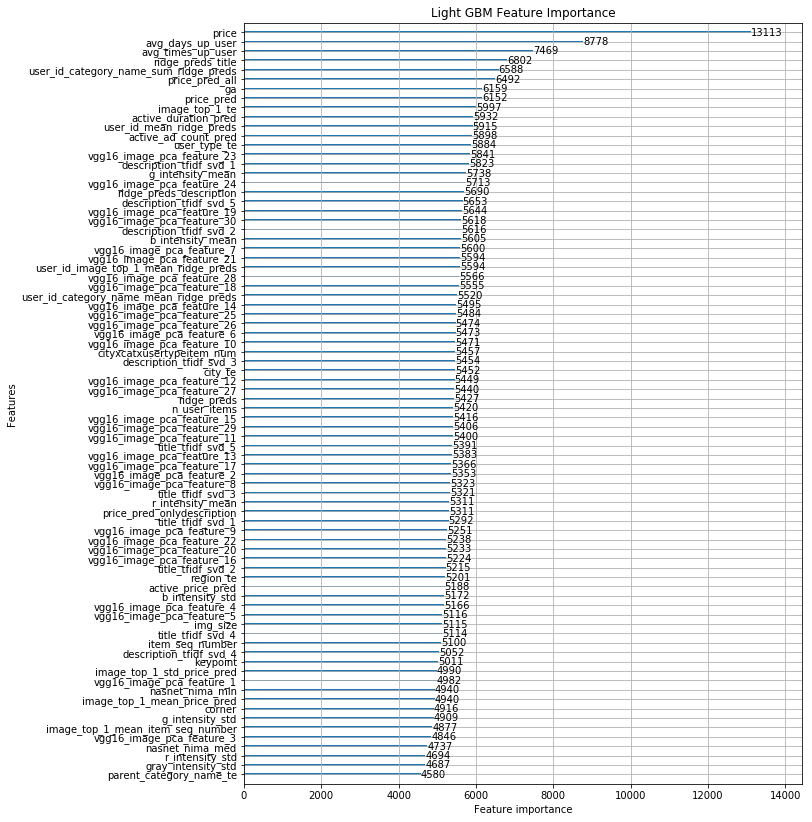

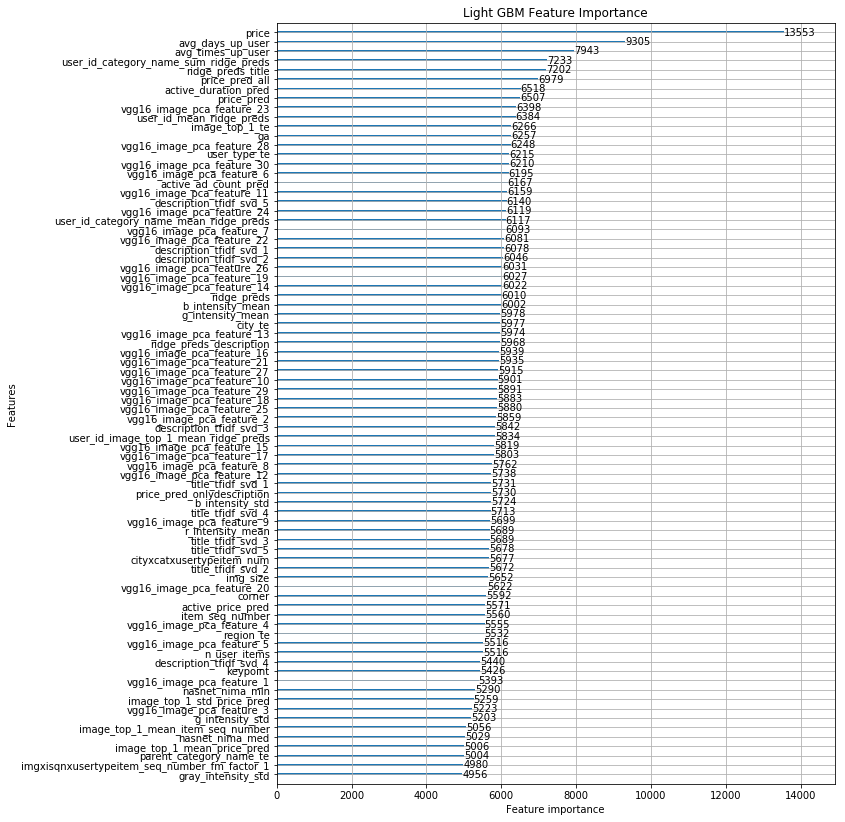

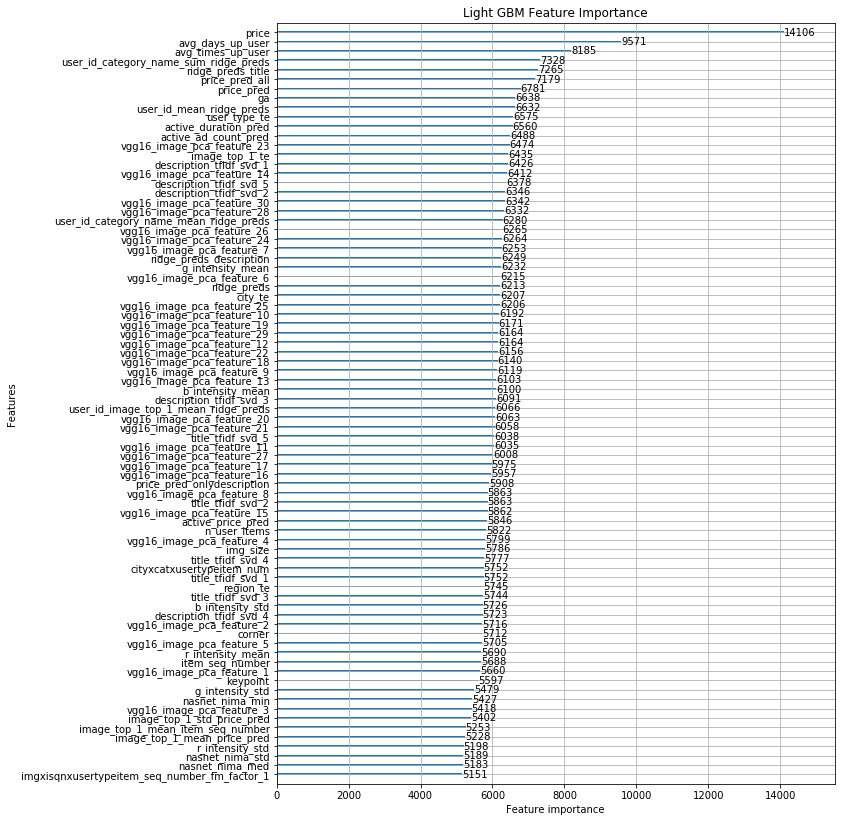

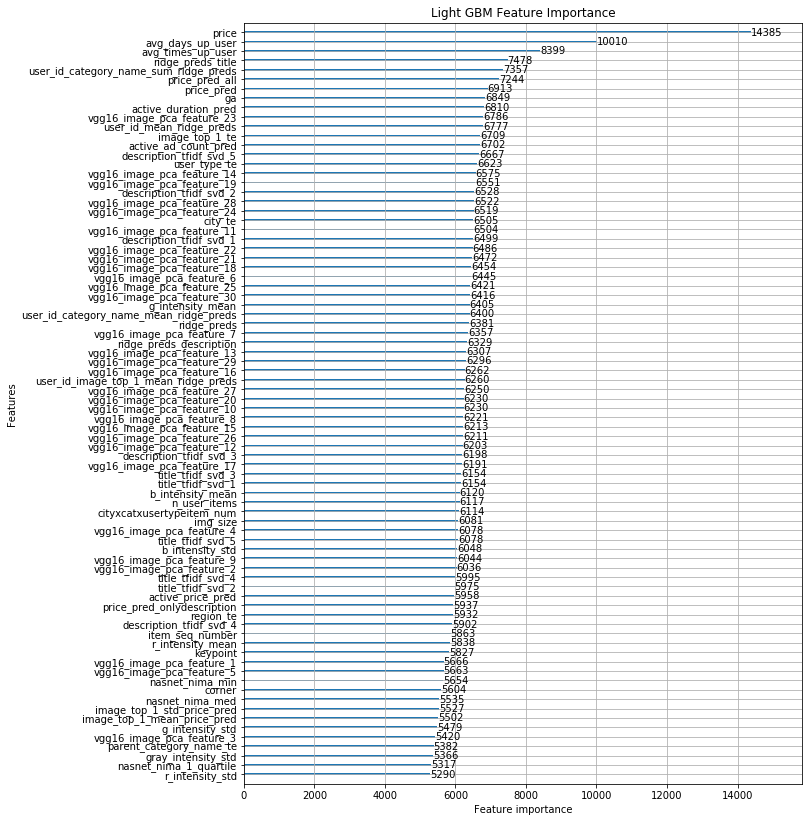

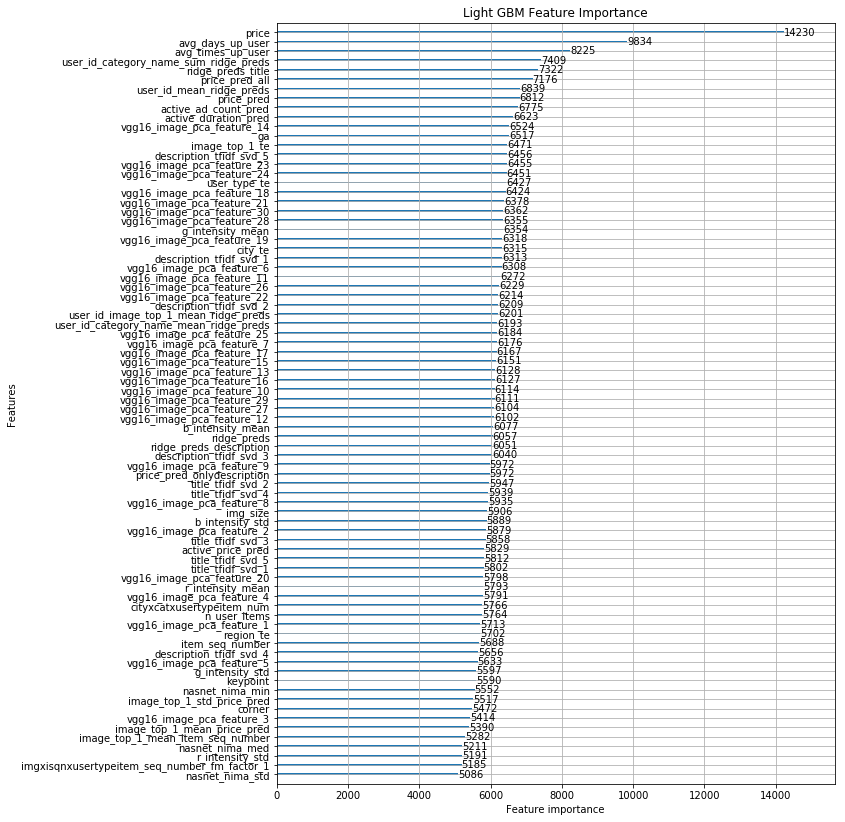

In [16]:
for model in ret_models:
    fig, ax = plt.subplots(figsize=(10, 14))
    lgb.plot_importance(model, max_num_features=80, ax=ax)
    plt.title("Light GBM Feature Importance")
    plt.show()

In [17]:
prefix = 'xentropy_add_lotsof_image_features_lgb519'

In [18]:
pd.DataFrame(data=ret, columns=[prefix+'_pred']).to_csv(prefix+'_oof_val_pred.csv', index=False)
pd.DataFrame(data=ret_test, columns=[prefix+'_pred']).to_csv(prefix+'_oof_test_pred.csv', index=False)

In [19]:
subm = pd.read_csv('sample_submission.csv')
subm['deal_probability'] = np.clip(ret_test, 0, 1)
subm.to_csv(prefix+'_submission.csv', index=False)

In [20]:
# origin: cv: .215172, lb: .2196
# with img meta+nima+fm+active: cv: .214405  lb: .2189
# with xentropy: cv: 0.213726  lb: 
# smaller lr (0.1 => 0.02): cv:.212952  lb: .2181
# finetuned: cv: .2124, lb: .2179
# new nima: cv:  lb: